In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.types as tp
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import when, sum, avg, col, count
from pyspark.sql.types import LongType, IntegerType
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import seaborn as sns 

spark = SparkSession.builder.appName("ChurnPredictions").config("spark.driver.memory", "128g").config("spark.sql.broadcastTimeout", "-1").getOrCreate()
sc = spark.sparkContext
# 
post_schema = tp.StructType([
    tp.StructField(name='PostId',                 dataType=tp.DecimalType(10),   nullable= True),
    tp.StructField(name='PostTypeId',             dataType=tp.DecimalType(10),    nullable= True),
    tp.StructField(name='AcceptedAnswerId',       dataType=tp.DecimalType(10),   nullable= True),
    tp.StructField(name='CreationDate',           dataType=tp.DateType(),    nullable= True),
    tp.StructField(name='Score',                  dataType=tp.DecimalType(10),    nullable= True),
    tp.StructField(name='OwnerUserId',            dataType=tp.DecimalType(10),    nullable= True),
    tp.StructField(name='AnswerCount',            dataType=tp.DecimalType(10),   nullable= True),
    tp.StructField(name='CommentCount',           dataType=tp.DecimalType(10),   nullable= True),
    tp.StructField(name='ParentId',               dataType=tp.DecimalType(10),   nullable= True),
    tp.StructField(name='CreationDateOfOwner',    dataType=tp.DateType(),   nullable= True),
    tp.StructField(name='BodyWordNum',            dataType=tp.DecimalType(10),   nullable= True),
])

users_schema = tp.StructType([
    tp.StructField(name= 'Id',      dataType= tp.DecimalType(10),   nullable= True),
    tp.StructField(name= 'CreationDate',  dataType= tp.DateType(),    nullable= True),
    tp.StructField(name= 'isChurn',  dataType= tp.BooleanType(),    nullable= True),
])
# "./data/posts_dist.csv"
# posts_dist_df = spark.read.csv("./data/posts_dist.csv", header=True)
posts_dist_df = spark.read.csv("./data/posts_dist.csv", schema=post_schema, header=True)
users_train_df = spark.read.csv("./data/users_train_dist.csv", header=True, schema=users_schema)
users_val_df = spark.read.csv("./data/users_val_dist.csv", header=True, schema=users_schema)
users_test_df = spark.read.csv("./data/users_test_dist.csv", header=True, schema=users_schema)


posts_dist_df = posts_dist_df.na.fill(0)
# Rename post creation date to avoid conflicts with users table
posts_dist_df = posts_dist_df.withColumnRenamed("CreationDate", "PostCreationDate")

posts_dist_df.printSchema()
users_train_df.printSchema()
users_val_df.printSchema()
users_test_df.printSchema()
posts_dist_df.show()
users_train_df.show()
users_val_df.show()
users_test_df.show()

root
 |-- PostId: decimal(10,0) (nullable = true)
 |-- PostTypeId: decimal(10,0) (nullable = true)
 |-- AcceptedAnswerId: decimal(10,0) (nullable = true)
 |-- PostCreationDate: date (nullable = true)
 |-- Score: decimal(10,0) (nullable = true)
 |-- OwnerUserId: decimal(10,0) (nullable = true)
 |-- AnswerCount: decimal(10,0) (nullable = true)
 |-- CommentCount: decimal(10,0) (nullable = true)
 |-- ParentId: decimal(10,0) (nullable = true)
 |-- CreationDateOfOwner: date (nullable = true)
 |-- BodyWordNum: decimal(10,0) (nullable = true)

root
 |-- Id: decimal(10,0) (nullable = true)
 |-- CreationDate: date (nullable = true)
 |-- isChurn: boolean (nullable = true)

root
 |-- Id: decimal(10,0) (nullable = true)
 |-- CreationDate: date (nullable = true)
 |-- isChurn: boolean (nullable = true)

root
 |-- Id: decimal(10,0) (nullable = true)
 |-- CreationDate: date (nullable = true)
 |-- isChurn: boolean (nullable = true)

+------+----------+----------------+----------------+-----+-----------+

In [2]:
train = posts_dist_df.join(users_train_df, posts_dist_df.OwnerUserId == users_train_df.Id).drop("OwnerUserId")
val = posts_dist_df.join(users_val_df, posts_dist_df.OwnerUserId == users_val_df.Id).drop("OwnerUserId")
test = posts_dist_df.join(users_test_df, posts_dist_df.OwnerUserId == users_test_df.Id).drop("OwnerUserId")
# train.show()
# print("#Post", posts_dist_df.count())
# print("#UserTrainData", users_train_df.count())
# print("#UserValData", users_val_df.count())
# print("#Joined TrainData", train.count())
# print("#Joined ValData", val.count())
# print("#Joined TestData", val.count())

# print(train.distinct().count())

In [4]:
from pyspark.sql import functions as F
from pyspark.sql.functions import when, sum, avg, col, count, stddev, round
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import Normalizer, MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

features = ['Questions', 'Answer', 'Early', 'Mid', 'Late', 'sum_scr','avg_scr', 'std_scr', 'sum_ans', 'avg_ans', 'std_ans', 'sum_cmt','avg_cmt', 'std_cmt', 'sum_wrd', 'avg_wrd', 'std_wrd','AcceptedAnswerCnt']

full_features = ["Id", "isChurn"] + features

def DaysDiffCategorizer(DaysDiff):
    if DaysDiff <= 30:
        return "early"
    elif DaysDiff < 210:
        return "mid"
    else:
        return "late"

def normalize_cols(col_names, df):
    assembler = VectorAssembler(inputCols=col_names, outputCol="features")
    # normalizer = MinMaxScaler(inputCol="features", outputCol="scaled")
    normalizer = StandardScaler(inputCol="features", outputCol="scaled", withStd=True, withMean=False)
    pipeline = Pipeline(stages=[assembler, normalizer])
    df = pipeline.fit(df).transform(df)

    # return df.select([c for c in df.columns if c not in col_names])
    return df.select("Id", "scaled", "isChurn")


def ExtractFeatures(df):
    # 1. Calculate DaysDiff between PostCreationDate and AccountCreationDate
    df = df.withColumn("DaysDiff", F.datediff(df['PostCreationDate'], df['CreationDate']))
    df = df.withColumn("DaysDiff", df["DaysDiff"].cast(IntegerType()))

    df = df.filter(df.DaysDiff >= 0)
    df = df.withColumn("DaysDiff", df["DaysDiff"].cast(IntegerType()))
    df = df.withColumn("Id", df["Id"].cast(IntegerType()))

    
    # 2. Binning DaysDiff into Early(~30), Mid(~210), Late(210~)
    bucket_udf = udf(DaysDiffCategorizer, StringType())
    df = df.withColumn("Time", bucket_udf("DaysDiff"))
    df = df.drop("DaysDiff").drop("PostCreationDate").drop("CreationDate")
    # df.show()

    # 3. Extract feature: total# of question/answer posts
    qnsPostCnt_df = df.groupBy("Id","PostTypeId").agg(
        when(col("PostTypeId") == "1", count("*")).alias("Question"),
        when(col("PostTypeId") == "2", count("*")).alias("Answer")
        ).drop("PostTypeId")
    qnsPostCnt_df = qnsPostCnt_df.groupBy("Id").sum()
    qnsPostCnt_df = qnsPostCnt_df.withColumnRenamed("sum(Question)", "Questions"). \
            withColumnRenamed("sum(Answer)", "Answer").drop("sum(Id)")

    qnsPostCnt_df = qnsPostCnt_df.na.fill(0)
    # dp.filter(dp.Id == 299).show()

    # 4. Extract feature: total# of posts per-interval (early, mid, late)
    time_df = df.groupBy("Id", "Time").agg(
        when(col("Time") == "early", count("*")).alias("EarlyPosts"),
        when(col("Time") == "mid", count("*")).alias("MidPost"),
        when(col("Time") == "late", count("*")).alias("LatePost"))
    time_df = time_df.na.fill(0)
    time_df = time_df.groupBy("Id").sum().drop("sum(Id)")
    time_df = time_df.withColumnRenamed("sum(EarlyPosts)", "Early"). \
                      withColumnRenamed("sum(MidPost)", "Mid"). \
                      withColumnRenamed("sum(LatePost)", "Late")
  
    # 5. Extract feature: sum,avg,stddev of each score, answercount, comments, bodywordnum
    stats_df = df.groupBy("Id").agg(
        sum("Score").alias("sum_scr"), \
        avg("Score").alias("avg_scr"), \
        round(stddev("Score"), 4).alias("std_scr"), \
        sum("AnswerCount").alias("sum_ans"), \
        avg("AnswerCount").alias("avg_ans"), \
        round(stddev("AnswerCount"), 4).alias("std_ans"), \
        sum("CommentCount").alias("sum_cmt"), \
        avg("CommentCount").alias("avg_cmt"), \
        round(stddev("CommentCount"), 4).alias("std_cmt"), \
        sum("BodyWordNum").alias("sum_wrd"), \
        avg("BodyWordNum").alias("avg_wrd"), \
        round(stddev("BodyWordNum"), 4).alias("std_wrd")) \
    .na.fill(0)
    # .show(truncate=False)


    
    # 6. Extract feature: Count per-user AcceptedAnswerCount, meaning how many user's answer posts are accepted by other users
    questionsPosts = df.filter(df.PostTypeId == 1).select('AcceptedAnswerId')
    answersPosts = df.filter(df.PostTypeId == 2).select('PostId', 'ParentId', 'Id').sort("PostId")
    qna = questionsPosts.join(answersPosts, questionsPosts["AcceptedAnswerId"] == answersPosts["PostId"], how="inner")
    qna = qna.withColumnRenamed("ParentId", "QuestionPostId")
    # qna = qna.withColumnRenamed("OwnerUserId", "Id")
    qna = qna.drop("PostId")
    qna = qna.groupBy("Id").agg(F.count("*").alias("AcceptedAnswerCnt"))
    # qna.show()

    churn_df = df.select("Id", "isChurn").distinct().sort("Id")

    # time_df
    # churn_df.show()
    # df.show()    
    # time_df.sort("Id").show()
    # qnsPostCnt_df.sort("Id").show()
    # 7 Join.
    result = qnsPostCnt_df.join(time_df, "Id").join(stats_df, "Id").join(qna, "Id", how="left").join(churn_df, "Id").na.fill(0)

    # 8 Normaliz
    scaled = normalize_cols(features, result)
    normalized_df = scaled.withColumn("scaled", vector_to_array("scaled")).select(["Id", "isChurn"] + [round(col("scaled")[i],3) for i in range(len(features))])
    final_df = normalized_df.toDF(*full_features)
    # result = result
    
    # result.show()
    return final_df

# 훈련 데이터 갯수 train_df.count() == 340721
train_df = ExtractFeatures(train)
val_df = ExtractFeatures(val)
test_df = ExtractFeatures(test)

In [77]:
train_df.show(truncate=False)

+-----+---------+------+-----+---+----+-------+-------+--------+-------+-------+-------+-------+-------+-------+-------+--------+--------+-----------------+-------+
|Id   |Questions|Answer|Early|Mid|Late|sum_scr|avg_scr|std_scr |sum_ans|avg_ans|std_ans|sum_cmt|avg_cmt|std_cmt|sum_wrd|avg_wrd |std_wrd |AcceptedAnswerCnt|isChurn|
+-----+---------+------+-----+---+----+-------+-------+--------+-------+-------+-------+-------+-------+-------+-------+--------+--------+-----------------+-------+
|148  |4        |49    |0    |40 |13  |1037   |19.5660|67.7483 |20     |0.3774 |1.547  |96     |1.8113 |2.2279 |5362   |101.1698|62.6801 |16               |false  |
|833  |0        |1     |0    |1  |0   |0      |0.0000 |0.0     |0      |0.0000 |0.0    |0      |0.0000 |0.0    |41     |41.0000 |0.0     |0                |false  |
|1088 |12       |315   |16   |65 |246 |3230   |9.8777 |69.2961 |50     |0.1529 |1.2364 |425    |1.2997 |2.1455 |30137  |92.1621 |82.2279 |38               |false  |
|1580 |20 

In [19]:
def ConvertToFeatureLabel(df, feature_cols):
    df = df.withColumn("isChurn" , F.when( F.col("isChurn")=="True" , F.lit(1) ).otherwise(0) )
    df = df.withColumnRenamed("isChurn", "label")
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df = assembler.transform(df)
    return df

train_df = ConvertToFeatureLabel(train_df, features)
test_df = ConvertToFeatureLabel(test_df, features)
val_df = ConvertToFeatureLabel(val_df, features)


In [20]:
from pyspark.ml.classification import LinearSVC

def Train(df, feature_cols):
    lsvc = LinearSVC(maxIter=10, regParam=0.1)
    model = lsvc.fit(df)
    return model

train_model = Train(train_df, features)


In [23]:
predictions = train_model.transform(test_df)
predictions.show()

+-----+-----+---------+------+-----+---+----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-----------------+--------------------+--------------------+----------+
|   Id|label|Questions|Answer|Early|Mid|Late|sum_scr|avg_scr|std_scr|sum_ans|avg_ans|std_ans|sum_cmt|avg_cmt|std_cmt|sum_wrd|avg_wrd|std_wrd|AcceptedAnswerCnt|            features|       rawPrediction|prediction|
+-----+-----+---------+------+-----+---+----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-----------------+--------------------+--------------------+----------+
|  463|    1|    0.422| 0.125|0.236|0.0| 0.0|  0.104|  0.234|  0.024|  0.377|  0.877|  1.853|    0.0|    0.0|    0.0|  0.152|  0.561|  0.305|              0.0|[0.422,0.125,0.23...|[-0.2185653642759...|       1.0|
| 2659|    0|    0.422| 1.003|1.063|0.0| 0.0|   1.46|  0.731|  0.988|  0.628|  0.325|  1.456|  0.424|  0.412|  1.648|  1.217|  0.996|  0.983|       

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName='areaUnderROC')

predictionAndTarget = train_model.transform(test_df).select("label", "prediction")
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
auc = evaluator.evaluate(predictionAndTarget)


In [26]:
print(f1)
print(auc)

0.7165338008796209
0.6706135136516691


In [5]:
import pandas as pd
train_pd = train_df.sample(False, 0.1, 0).toPandas()

In [8]:
# Explore random sampled data in pandas form
train_pd.columns

Index(['Id', 'Questions', 'Answer', 'Early', 'Mid', 'Late', 'sum_scr',
       'avg_scr', 'std_scr', 'sum_ans', 'avg_ans', 'std_ans', 'sum_cmt',
       'avg_cmt', 'std_cmt', 'sum_wrd', 'avg_wrd', 'std_wrd',
       'AcceptedAnswerCnt', 'isChurn'],
      dtype='object')

       Questions    Answer     Early       Mid      Late   std_scr   std_ans  \
count   34320.00  34320.00  34320.00  34320.00  34320.00  34320.00  34320.00   
mean        4.96      9.65      2.45      3.84      8.33      5.16      0.65   
std        16.70     77.02      7.25     18.27     70.25     23.37      1.03   
min         0.00      0.00      0.00      0.00      0.00      0.00      0.00   
25%         1.00      0.00      1.00      0.00      0.00      0.00      0.00   
50%         1.00      1.00      1.00      0.00      0.00      0.60      0.00   
75%         3.00      3.00      2.00      2.00      2.00      3.01      1.11   
max       568.00   8152.00    406.00    980.00   8070.00   1469.36     20.51   

        std_cmt   std_wrd  AcceptedAnswerCnt  
count  34320.00  34320.00           34320.00  
mean       0.84     42.16               1.97  
std        1.14     64.74              17.13  
min        0.00      0.00               0.00  
25%        0.00      0.00               0.00

<AxesSubplot:>

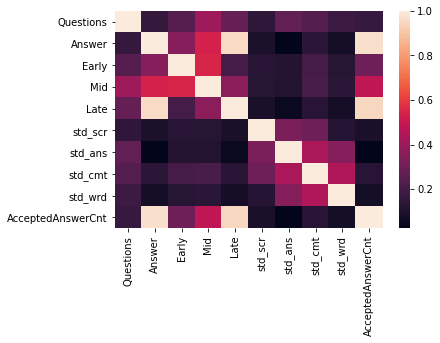

In [19]:
# Explore random sampled data in pandas form
from pandas.plotting import scatter_matrix 

# pd.set_option("display.max.columns", None)
features = ['Questions', 'Answer', 'Early', 'Mid', 'Late', 'sum_scr','avg_scr', 'std_scr', 'sum_ans', 'avg_ans', 'std_ans', 'sum_cmt','avg_cmt', 'std_cmt', 'sum_wrd', 'avg_wrd', 'std_wrd','AcceptedAnswerCnt']

# # feature_pd = train_pd[map(lambda x :x in features, list(train_pd.columns))]
# extract feature columns
pd.set_option("display.precision", 2)
feature_pd = train_pd.loc[:, train_pd.columns.isin(features)]
print(feature_pd.describe())
print(feature_pd.tail())
print(feature_pd.info())
# feature_pd.describe()
print(feature_pd.columns)
feature_pd_corr = feature_pd.corr()
sns.heatmap(feature_pd_corr, 
        xticklabels=feature_pd_corr.columns,
        yticklabels=feature_pd_corr.columns)
# scatter_matrix(train_pd[features])
# plt.show()


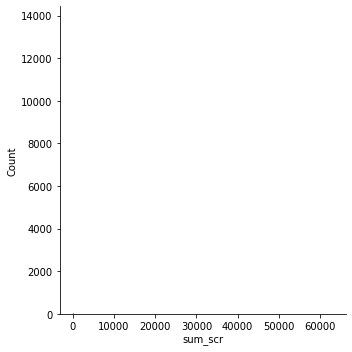

In [29]:
# sns.displot(feature_pd, x="sum_scr", binwidth=3, bins=20)

In [181]:
# PCA for dimension reduction
from pyspark.ml.feature import PolynomialExpansion, PCA
from pyspark.ml.linalg import Vectors
features = ["Questions", "Answer", "Early", "Mid", "Late", "sum_scr", "avg_scr", "std_scr", "sum_ans", "avg_ans", "std_ans", "sum_cmt", "avg_cmt", "std_cmt", "sum_wrd", "avg_wrd", "std_wrd", "AcceptedAnswerCnt"]

def dimension_reduction(df, cols):
    assembler = VectorAssembler(inputCols=cols,outputCol="features")
    # polyExpansion = PolynomialExpansion(degree=3, inputCol="features", outputCol="polyFeatures")
    pca = PCA(k=8, inputCol="features", outputCol="pcaFeatures")
    pipeline = Pipeline(stages=[assembler, pca])
    df = pipeline.fit(df).transform(df)
    return df.select([c for c in df.columns if c not in cols])

train_reduction_df = dimension_reduction(train_df, features)
train_reduction_df.show(truncate = False)


+-----+-------+----------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id   |isChurn|features                                                                                                              |pcaFeatures                                                                                                                                                   |
+-----+-------+----------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|148  |false  |[4.0,49.0,0.0,40.0,13.0,1037.0,19.566,67.7483,20.0,0.3774,1.547,96.0,1.8113,2.2279,5362.0,101.1698,62.6

In [52]:
from pyspark.ml.feature import Normalizer, MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from joblib import Parallel, delayed
from pyspark.ml.functions import vector_to_array


def normalize_cols(col_names, df):
    assembler = VectorAssembler(inputCols=col_names, outputCol="features")
    # normalizer = MinMaxScaler(inputCol="features", outputCol="scaled")
    normalizer = StandardScaler(inputCol="features", outputCol="scaled", withStd=True, withMean=False)
    pipeline = Pipeline(stages=[assembler, normalizer])
    df = pipeline.fit(df).transform(df)

    # return df.select([c for c in df.columns if c not in col_names])
    return df.select("Id", "scaled", "isChurn")

# train_df.sample(False, 0.001, seed=0).rdd.countApprox(timeout = 1000, confidence = 0.90)

scaled = normalize_cols(features, train_df)
# train_norm_df.printSchema()
# train_norm_df.sample(False, 0.1, seed=0).limit(1).show()
# train_norm_df.show()


In [73]:
# vecotr 를 칼럼으로 다시 쪼개기.
normalized_df = scaled.withColumn("scaled", vector_to_array("scaled")).select(["Id", "isChurn"] + [round(col("scaled")[i],3) for i in range(len(features))])



In [74]:
# columns are re-named..
full_features = ["Id", "isChurn", "Questions", "Answer", "Early", "Mid", "Late", "sum_scr", "avg_scr", "std_scr", "sum_ans", "avg_ans", "std_ans", "sum_cmt", "avg_cmt", "std_cmt", "sum_wrd", "avg_wrd", "std_wrd", "AcceptedAnswerCnt"]
# final_df = normalized_df.toDF(*features)
# final_df = final_df.withColumn("Id", train_df.select(col("Id")))
# print(train_df.select(col("Id")).collect())
# Construct the final train df
final_df = normalized_df.toDF(*full_features).show(truncate=False)

+-----+-------+---------+------+-----+-----+-----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-----------------+
|Id   |isChurn|Questions|Answer|Early|Mid  |Late |sum_scr|avg_scr|std_scr|sum_ans|avg_ans|std_ans|sum_cmt|avg_cmt|std_cmt|sum_wrd|avg_wrd|std_wrd|AcceptedAnswerCnt|
+-----+-------+---------+------+-----+-----+-----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-----------------+
|148  |false  |0.232    |0.615 |0.0  |1.889|0.186|1.442  |0.705  |2.47   |0.427  |0.261  |1.498  |0.609  |1.305  |1.942  |0.651  |1.032  |0.929  |0.774            |
|833  |false  |0.0      |0.013 |0.0  |0.047|0.0  |0.0    |0.0    |0.0    |0.0    |0.0    |0.0    |0.0    |0.0    |0.0    |0.005  |0.418  |0.0    |0.0              |
|1088 |false  |0.697    |3.955 |2.122|3.07 |3.517|4.492  |0.356  |2.527  |1.069  |0.106  |1.197  |2.696  |0.937  |1.87   |3.657  |0.94   |1.219  |1.839            |
|1580 |fal

In [86]:
# train_df.repartition(1).write.format('com.databricks.spark.csv').save("./train_df.csv", header = 'true')
# train.repartition(1).write.format('com.databricks.spark.csv').save("./train.csv",header = 'true')
# val.repartition(1).write.format('com.databricks.spark.csv').save("./val.csv",header = 'true')

In [ ]:
val_df = ExtractFeatures(posts_dist_df, users_val_dist_df)
val_df.show()

In [ ]:
val_df_transformed = assembler.transform(val_df)
final_df = train_df_transformed.select(col("isChurn").alias("label"), col("features"))
lsvcModel.predict()

In [ ]:
# Construct validation x,y
val_x = users_val_dist_df.join(posts_dist_df, posts_dist_df.OwnerUserId == users_val_dist_df.Id)
val_x.show()

In [ ]:
ppdf = train_df.toPandas()
